# Predicting Medical Insurance Cost using Ensemble Methods

Data science and machine learning can be apllied in many areas and multiple domains. Today, I will aplly my humble knowledge of ML in the medical field, by giving predictions for insurance prices, which can be useful in various situations.  
The aim of this project is to predict the cost of meeical insurance using data of different people. It is a simple project that helpd me practice the basics of Machine Learning that I learned online.  
The strategy for the project is following:  

- Import the data and various libraries
- A Data exploration phase
- Data preprocessing and creation of sets
- Choice of a model and testing the model

## Import the data and libraries:

In [8]:
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Even if it isn't necessary is our case, we can create a funcion to save the plots or images on our computer, which can be useful for certain projects.

In [13]:
project_root_dir = "."
images_path = os.path.join(project_root_dir, "images")
os.makedirs(images_path, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(images_path, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Next we can import our dataset which is in a CSV format. We use Pandas to open the CSV

In [14]:
housing_path = os.path.join("datasets", "insurance.csv")

def load_insurance_data(housing_path=housing_path):
    csv_path = housing_path
    return pd.read_csv(csv_path)

insurance = load_insurance_data()
print(insurance.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


This is what our dataset looks like! We can see that it contains some basic data about the patients, and of course the charges, which are the insurance costs.

## Data Exploration phase:

We can use the "describe" method of our dataframe to obtain some additional information. For example, we can see that there is no missing data, or we observe the ranges for different numerical features.

In [15]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


We can further explore our dataset with some visualisation tools: the previous "describe" method gives a lot of information, but plotting the data (with histograms) should give us a better idea of the distribution.

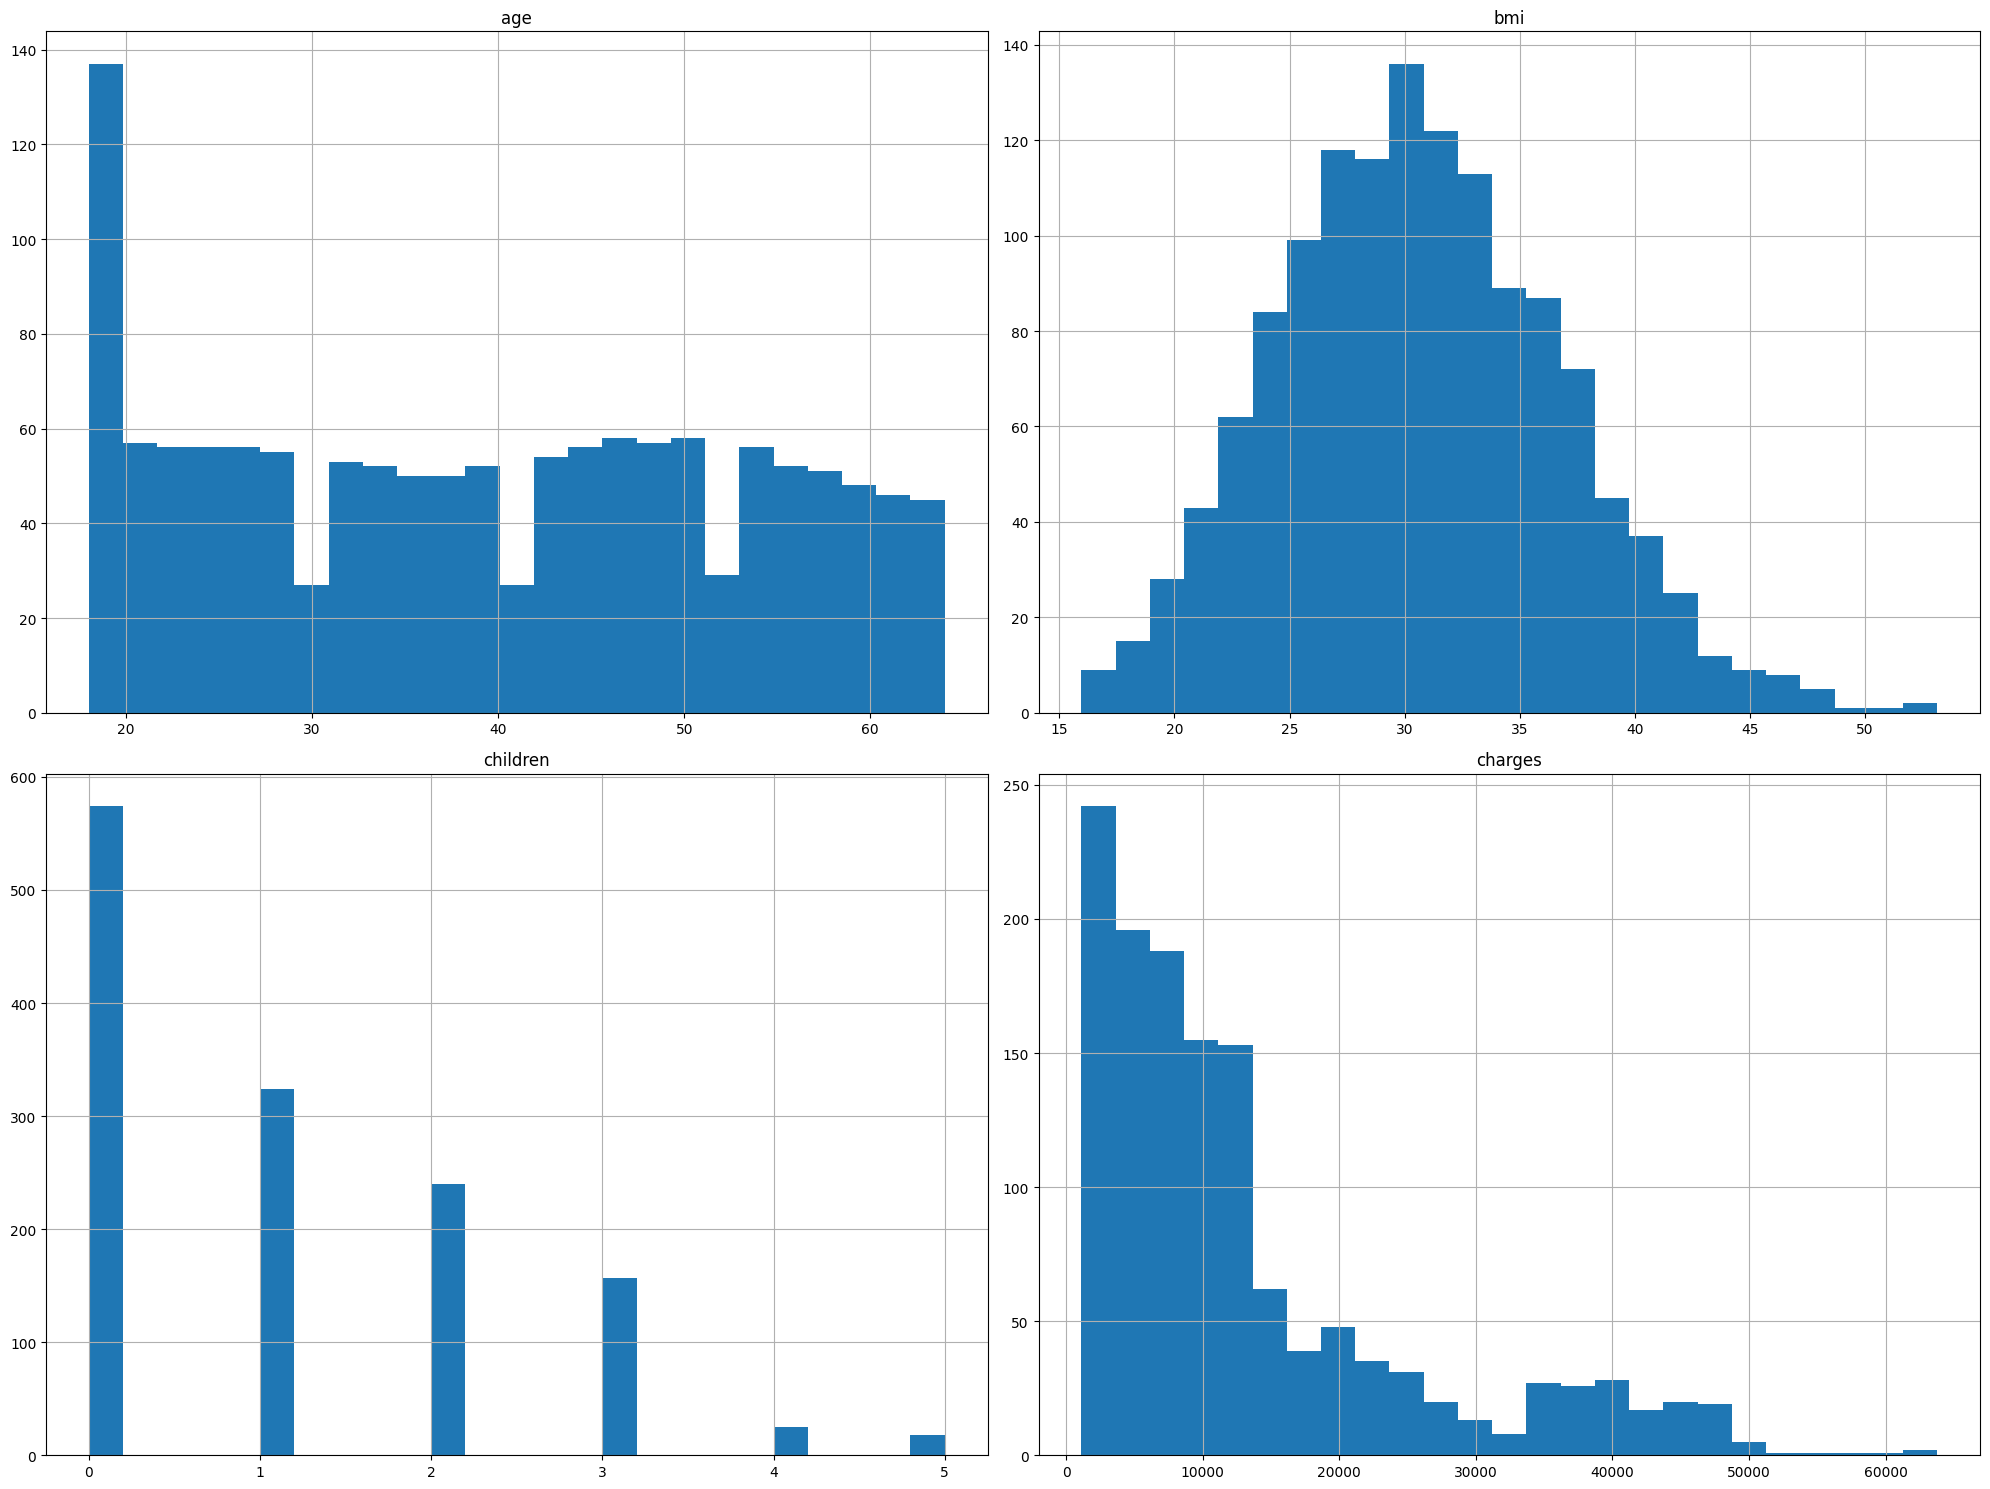

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
insurance.hist(bins=25, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Fun fact: if we observe the distribution for the charges, it most resembles a normal distribution, which is quite often the case when gathering data from enough people.

## Data Preprocessing and Creation of Training/Test Sets:

For practical resaons we will set a seed in the notebook to have the same results if we run it multiple times.

In [17]:
np.random.seed(42)

We then use the **train_test_split** function from sklearn to create sets of data for training the model and then testing it. This is how it's done :

In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)

Quick look at the test set, to check if rows are randomly selected:

In [20]:
test_set.head()

,age,sex,bmi,children,smoker,region,charges
764,45,female,25.175,2,no,northeast,9095.06825
887,36,female,30.020,0,no,northwest,5272.17580
890,64,female,26.885,0,yes,northwest,29330.98315
1293,46,male,25.745,3,no,northwest,9301.89355
259,19,male,31.920,0,yes,northwest,33750.29180


Now we will work on the training set only, so we make a copy of it before modifications:

In [21]:
insurance = train_set.copy()

Let's continue our Data Exploration phase : we can first take a look at how the charges behave with the age of the patients. The reason for this plot is that we want to see if there is a direct "link" between age and medical charges for insurance. Let's check:

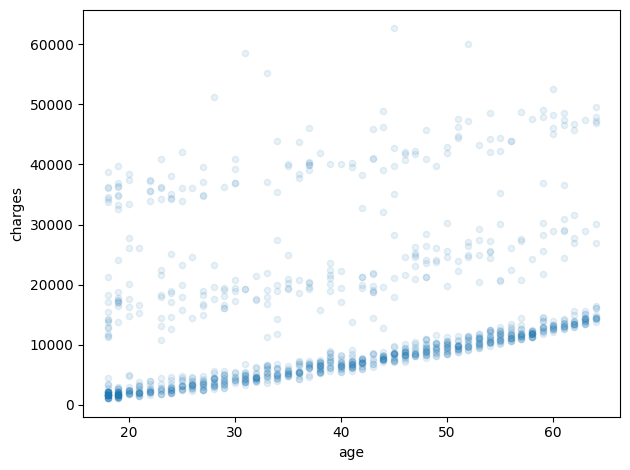

In [22]:
insurance.plot(kind="scatter",x="age",y="charges",alpha=0.1)
save_fig("visualization_charges_against_age")

By setting the "alpha" to 0.1, we can modify the transparency of the plot. This is helpful because it is easier to see higher density of points on the graph. Looking at the plot, we can see that there is a strong density at the bottom, and some points at the top, less densely dispatched.

Another technique when exploring your data is to look for correlations between different features. For that, we can use the **corr()** method for a dataframe, by only selecting the numerical features of the dataset.

In [24]:
insurance_num = insurance[["age","bmi","children","charges"]]
corr_matrix = insurance_num.corr()
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.281721
bmi         0.197316
children    0.071885
Name: charges, dtype: float64

**Comments on the correlation matrix** : we can see that the "age" feature  has the highest correlation with the "charges". So when predicting the amount of charges for a patient, it would be more important to ask for their age rather than the number of children. Also the "BMI" fetaure (Body Mass Index) is also somewhat correlated with charges.

We can also plot a **Scatter Matrix**, which is simply a matrix of scatterplots. This matrix will allow us to visualise the relationship between multiple features at once.

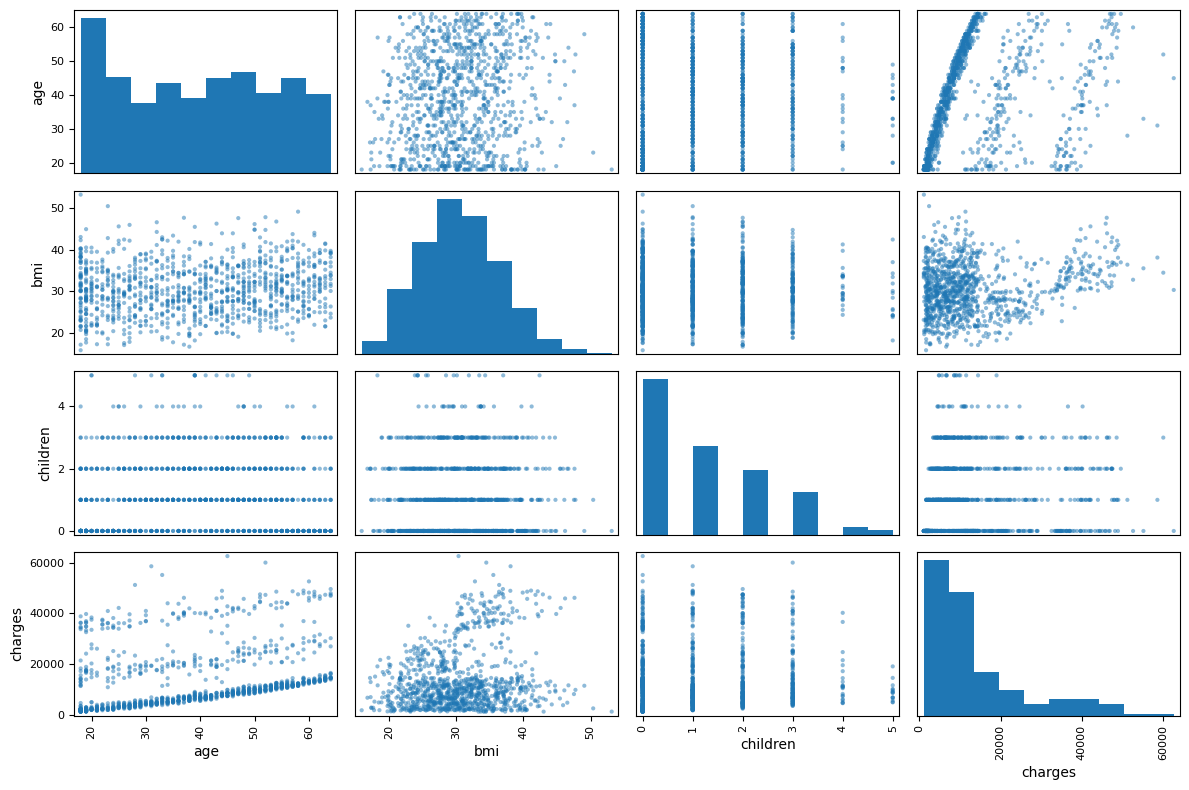

In [25]:
from pandas.plotting import scatter_matrix

scatter_matrix(insurance_num, figsize=(12, 8))
save_fig("scatter_matrix_plot")

__Remark__ : You can also experiment with new parameters by trying new combinations ; in our case the number of numeric attribute is too low so we wil not try to combine them. If the model is not performing good enough we can try to come back here to add other attributes with hiden correlation.

Now it is time to "clean" our data and make it ready to go into the model: we will first drop the aim column ("charges" column).

In [26]:
insurance = train_set.drop("charges", axis=1) 
insurance_num = insurance[["age","bmi","children"]]
insurance_labels = train_set["charges"].copy()

In [27]:
sample_incomplete_rows = insurance[insurance.isnull().any(axis=1)].head()
sample_incomplete_rows

,age,sex,bmi,children,smoker,region


__Remark__ : here we can see that the dataset is well constructed as there are no missing values ! 

__Other Remark__ : On a more serious note, we chose this dataset because it was easy to use. In reality the datasets are almost never complete and they require good amout of cleaning.

To handle text and categorical attributes, we can use the **OneHotEncoder** from sklearn: it transforms our data so that our "non-numerical" data becomes numerical!

In [30]:
insurance_cat = insurance[["sex","smoker","region"]]
insurance_cat.head(10)

,sex,smoker,region
560,female,no,northwest
1285,female,no,northeast
1142,female,no,southeast
969,female,no,southeast
486,female,no,northwest
170,male,no,southeast
277,female,no,southwest
1033,male,yes,northeast
209,male,no,northeast
947,male,yes,northeast


In [31]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
insurance_cat_1hot = cat_encoder.fit_transform(insurance_cat)
insurance_cat_1hot

<1070x8 sparse matrix of type '<class 'numpy.float64'>'
	with 3210 stored elements in Compressed Sparse Row format>

In [32]:
cat_encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

Another technique is to create custom transformers: custom transformers are used to build custom cleaning operations or to combine specific attributes. Here we have too few attributes in the dataset, so we will try to continue without implementing new attributes. For illustration purposes this is what a custom transformer could look like :

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

Let's build some pipelines for the transformation of our data :

__Remark__ : The first pipeline (pipeline_num) is used to apply the needed transformations (handling missing values and scaling the values) on the numerical atrributes.
The second pipeline (full_pipeline) is used to combine the transformations on numerical attributes and the transformations on the categorical (or non numerical) attributes.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

insurance_num_tr = num_pipeline.fit_transform(insurance_num)

In [35]:
insurance_num_tr

array([[ 0.47222651, -1.75652513,  0.73433626],
       [ 0.54331294, -1.03308239, -0.91119211],
       [ 0.8987451 , -0.94368672, -0.91119211],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211],
       [-0.16755139,  2.82086429,  0.73433626],
       [ 1.1120044 , -0.10932713, -0.91119211]])

__Remark__ : Here the SimpleImputer() transformer is only there for illustration purposes. We already checked that there were no missing values in the dataset. If it was the case we could have used this method.

In [36]:
from sklearn.compose import ColumnTransformer

num_attribs = ["age","bmi","children"]
cat_attribs = list(insurance_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

insurance_prepared = full_pipeline.fit_transform(insurance)

In [37]:
insurance_prepared

array([[ 0.47222651, -1.75652513,  0.73433626, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.54331294, -1.03308239, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8987451 , -0.94368672, -0.91119211, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16755139,  2.82086429,  0.73433626, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.1120044 , -0.10932713, -0.91119211, ...,  0.        ,
         0.        ,  1.        ]])

In [38]:
insurance_prepared.shape

(1070, 11)

## Choice of a Model and Testing Phase :

Let's first try a linear regression :

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(insurance_prepared, insurance_labels)

LinearRegression()

Let's try the full preprocessing pipeline on a few training samples: 

In [40]:
some_data = insurance.iloc[:5]
some_labels = insurance_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 6656.  8704.  9216. 10752.  9536.]


In [41]:
print("Labels:", list(some_labels))

Labels: [9193.8385, 8534.6718, 27117.99378, 8596.8278, 12475.3513]


In [42]:
from sklearn.metrics import mean_squared_error

insurance_predictions = lin_reg.predict(insurance_prepared)
lin_mse = mean_squared_error(insurance_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6113.551151636188

In [43]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(insurance_labels, insurance_predictions)
lin_mae

4282.680959299066

Let's now try a Decision Tree Regressor :

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(insurance_prepared, insurance_labels)

DecisionTreeRegressor(random_state=42)

In [45]:
insurance_predictions = tree_reg.predict(insurance_prepared)
tree_mse = mean_squared_error(insurance_labels, insurance_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


494.20598375812835

We can try to get a better evaluation using **Cross-Validation** :

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, insurance_prepared, insurance_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [6339.58900717 6578.46280707 7070.94331065 7082.71162807 7035.35755633
 6537.63856176 7436.65224436 7411.85619806 6621.32660141 5569.81488004]
Mean: 6768.4352794914985
Standard deviation: 534.1938075533002


In [47]:
lin_scores = cross_val_score(lin_reg, insurance_prepared, insurance_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6088.62821183 6579.03828457 5218.86367097 6042.09621288 5843.70905614
 6177.20119308 7212.64087053 6318.98648379 6191.88536253 5669.09794393]
Mean: 6134.214729025356
Standard deviation: 504.9102849483168


Let's now try a Random Forest Regressor : it works by training many Decision Trees on random subsets of the features, then averaging out their predictions. 

In [48]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(insurance_prepared, insurance_labels)

insurance_predictions = forest_reg.predict(insurance_prepared)
forest_mse = mean_squared_error(insurance_labels, insurance_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1900.9799788695125

Let's get the CV Score for the Random Forest Regressor :

In [49]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, insurance_prepared, insurance_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [4837.88091145 5321.29233914 3855.38071452 4444.14090314 5283.52272899
 4882.71894641 5656.0522389  5424.90384931 5177.82380257 4687.58891207]
Mean: 4957.130534650082
Standard deviation: 506.4164192696564


 Conclusion : the Random Forest Regressor seems to be the best performing model.

##  Bonus Part, Fine-tuning the selected model (Random Forest Regressor) :

We will try to get the best version possible of our model. For that, we can look for the best hyperparameters, which are parameters that are set at the beginning of training and that are not learned. The **GridSearchCV** method allows us to do two things at the same time:

- The GridSearch part : different combinations of parameters are tested in the model to see whiwh one works best.
- The CrossValidation part : to test each combination og hyperparameters, we do not just run the model once; instead we use the CV method by using a number k of folds. We then train the model on k-1 folds and test it one the remaining fold. Of course we reiterate as many times as the number of folds we decided to have.

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4, 5]},
    # (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(insurance_prepared, insurance_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 3, 4, 5],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [59]:
grid_search.best_params_

{'max_features': 5, 'n_estimators': 30}

In [60]:
grid_search.best_estimator_

RandomForestRegressor(max_features=5, n_estimators=30, random_state=42)

In [61]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5869.472669568795 {'max_features': 2, 'n_estimators': 3}
5344.09974595216 {'max_features': 2, 'n_estimators': 10}
5043.721468813344 {'max_features': 2, 'n_estimators': 30}
5648.138086537294 {'max_features': 3, 'n_estimators': 3}
5105.500999588195 {'max_features': 3, 'n_estimators': 10}
4893.003223784434 {'max_features': 3, 'n_estimators': 30}
5408.495942571259 {'max_features': 4, 'n_estimators': 3}
4917.741867902749 {'max_features': 4, 'n_estimators': 10}
4819.911075212028 {'max_features': 4, 'n_estimators': 30}
5329.890795940145 {'max_features': 5, 'n_estimators': 3}
4945.846057937126 {'max_features': 5, 'n_estimators': 10}
4791.773863128718 {'max_features': 5, 'n_estimators': 30}
5824.642078297096 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
5360.687013306672 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
5590.669350674112 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
5215.110265030829 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

In [54]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.14203938, 0.18778845, 0.02184478, 0.00542714, 0.00411807,
       0.27403738, 0.34359555, 0.00547049, 0.00498177, 0.00657547,
       0.00412152])

In [55]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.18778844973966602, 'bmi'),
 (0.14203937513086864, 'age'),
 (0.02184477637216532, 'children'),
 (0.005427140684887419, 'female'),
 (0.004118072604870407, 'male')]

## Last step of the project: Testing the Model !

We are now going to test our model on the test set ! Because our problem is a regression problem, we have to measure the accuracy of our model with the RMSE (Root Mean Squared Error). Let's see how our model is doing :

In [62]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("charges", axis=1)
y_test = test_set["charges"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

4592.411834803969

We can also compute a 95% confidence interval for the test RMSE :

In [57]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([3615.44349268, 5395.28138953])